In [3]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

     |████████████████████████████████| 1.1MB 6.2MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 358kB 15.3MB/s 
     |████████████████████████████████| 174kB 14.7MB/s 
     |████████████████████████████████| 37.6MB 1.4MB/s 
     |████████████████████████████████| 102kB 8.1MB/s 
     |████████████████████████████████| 1.2MB 45.8MB/s 
     |████████████████████████████████| 706kB 18.1MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=c4721e9aa393c0e4d65e3a75ff055a9067fa6cc547ed975ca91cc32b7e8d5581
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-cp37-none-any.whl size=22245 sha256=5b67770eca96e132623d9613b14b40d9d7372d03a529d3338c44bf64c0f9d253
  Stored in directory: /root/.cache/pip/wheels/2e/15/f5/aa2a056d223903b52cf4870134e3a01df0c723816835dd08db
Successfully built seqeval py-

In [4]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [5]:
df = pd.read_csv("DATASET_DETOXIS.csv")

In [6]:
df.head()

,topic,thread_id,comment_id,reply_to,comment_level,comment,argumentation,constructiveness,positive_stance,negative_stance,target_person,target_group,stereotype,sarcasm,mockery,insult,improper_language,aggressiveness,intolerance,toxicity,toxicity_level
0,CR,0_000,0_002,0_002,1,Pensó: Zumo para restar.,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,CR,0_001,0_003,0_003,1,Como les gusta el afeitado en seco a esta gente.,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1
2,CR,0_002,0_004,0_004,1,"asi me gusta, que se maten entre ellos y en al...",0,0,0,0,0,1,0,0,0,0,0,1,1,1,2
3,CR,0_003,0_005,0_005,1,"Loss mas valientes, los que mejor cortan nuest...",0,0,0,0,1,1,0,1,1,0,0,0,0,1,1
4,CR,0_004,0_006,0_006,1,Costumbres...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1


In [7]:
df.toxicity.unique()

array([1, 0])

In [9]:
sample_size = int(len(df)*0.05)
sampleDf = df.sample(sample_size, random_state=23)
x = sampleDf.comment.values
y = sampleDf.toxicity.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

In [26]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [10]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [11]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [12]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [13]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [14]:
print('Tokenized Tweets shape', tweets.shape.as_list())

Tokenized Tweets shape [138, None]


In [15]:

tweets[0]

<tf.Tensor: shape=(18,), dtype=int32, numpy=
array([12954, 92952, 10107, 18419,   119,   119,   119, 82493, 13741,
       11197,   117, 10192, 18278, 10157, 13672, 13436, 81746,   102],
      dtype=int32)>

In [16]:
x_train[0]

'sencillas sí... inteligentes, no estoy yo muy seguro'

In [17]:

tokenizedTweet = tokenizer.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizer.convert_tokens_to_ids([i]))

sen [12954]
##cilla [92952]
##s [10107]
sí [18419]
. [119]
. [119]
. [119]
intel [82493]
##igen [13741]
##tes [11197]
, [117]
no [10192]
esto [18278]
##y [10157]
yo [13672]
muy [13436]
seguro [81746]


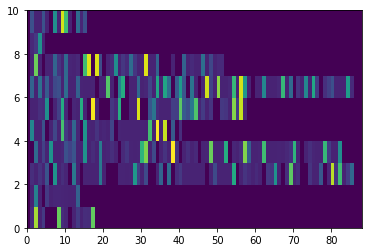

In [18]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

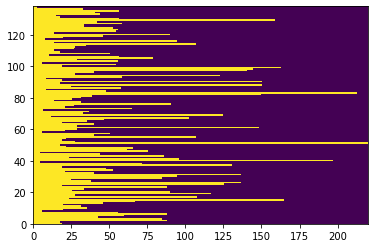

In [19]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

In [20]:
lens = [len(i) for i in input_word_ids]

In [21]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 220


In [22]:

max_seq_length = int(1.5*max_seq_length)
print('Max length is:', max_seq_length)

Max length is: 330


In [23]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [24]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [27]:

num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

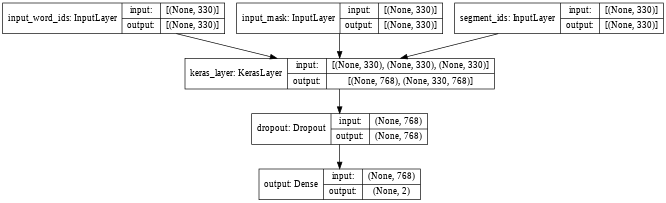

In [28]:

tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [29]:
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [30]:

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 330)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 330)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 330)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [32]:

history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
9/9 [==============================] - 651s 69s/step - loss: 0.6704 - accuracy: 0.6166 - val_loss: 0.5781 - val_accuracy: 0.7714
Epoch 2/3
9/9 [==============================] - 618s 69s/step - loss: 0.6272 - accuracy: 0.6334 - val_loss: 0.6357 - val_accuracy: 0.7143
Epoch 3/3
9/9 [==============================] - 628s 70s/step - loss: 0.5701 - accuracy: 0.8627 - val_loss: 0.6314 - val_accuracy: 0.7143
